<a href="https://colab.research.google.com/github/MustafaKhan670093/YouTube-Channel-Projects/blob/main/HYPER-REALITY/(modified)_skymagic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Foreword**

Hey everyone! It's Mustafa, hope you're doing well. This repository was created by the authors of the [**Castle in the Sky: Dynamic Sky Replacement and Harmonization in Videos**](https://arxiv.org/pdf/2010.11800.pdf) research paper. I make use of this in the [**HYPER-REALITY: Replacing The Sky Using Programming**](https://www.youtube.com/watch?v=W30_24D6fH4). I encourage you to go through the open source code they provide and dig into the paper as well. At the bottom of this notebook you will also see some of the behind the scenes footage I used in the video.

This notebook provides an minimal working example of the sky augmentation in the preprint paper "Castle in the Sky: Dynamic Sky Replacement and Harmonization in Videos, arXiv:2010.11800"

[Project Page](https://jiupinjia.github.io/skyar/) | [GitHub](https://github.com/jiupinjia/SkyAR) | [Preprint](https://arxiv.org/abs/2010.11800)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">   The project </a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In [ ]:
# Clone the repository
!git clone https://github.com/jiupinjia/SkyAR.git 

fatal: destination path 'SkyAR' already exists and is not an empty directory.


In [ ]:
cd SkyAR

/content/SkyAR


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import argparse
from networks import *
from skyboxengine import *
import utils
import torch

%matplotlib inline

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Download pretrained sky matting model

In [ ]:
# Define some helper functions for downloading pretrained model
# taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
# download and unzip...
file_id = '1COMROzwR4R_7mym6DL9LXhHQlJmJaV0J'
destination = './checkpoints_G_coord_resnet50.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
!unzip checkpoints_G_coord_resnet50.zip

Archive:  checkpoints_G_coord_resnet50.zip
replace checkpoints_G_coord_resnet50/best_ckpt.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace checkpoints_G_coord_resnet50/best_ckpt.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: checkpoints_G_coord_resnet50/best_ckpt.pt  


Config your model...

In [ ]:
parser = argparse.ArgumentParser(description='SKYAR')
args = utils.parse_config(path_to_json='./config/config-annarbor-castle.json')

In [ ]:
#config the following if you would like to see a different stlyle

args.net_G = "coord_resnet50"
args.ckptdir = "./checkpoints_G_coord_resnet50"

args.datadir = "/content/IMG_3059.MOV" # choose a foreground video
args.skybox = "ufo.png" # choose a skybox template

args.in_size_w = 384 # input size to sky matting model
args.in_size_h = 384 # ...
args.out_size_w = 845 # output video resolution
args.out_size_h = 480 # ...

args.skybox_center_crop = 0.5 # view of the virtual camera
args.auto_light_matching = False 
args.relighting_factor = 0.8
args.recoloring_factor = 0.5
args.halo_effect = True

In [ ]:
#config the following if you would like to see a different stlyle
#Note from Mustafa: I altered the sizes here so the video output was larger. 
#I added custom image/video files to the Skybox folder while vdeo files were placed anywhere.
#Additionally, Google Colab has RAM restrictions so if you want to replace the background of a sky with a video
#then be cautious because your session can crash if you use up too much RAM.

args.net_G = "coord_resnet50"
args.ckptdir = "./checkpoints_G_coord_resnet50"

args.datadir = "/content/first-drive.mp4" # choose a foreground video
args.skybox = "gold-cloud.jpg" # choose a skybox template

args.in_size_w = 768 # input size to sky matting model
args.in_size_h = 768 # ...
args.out_size_w = 1280 # output video resolution
args.out_size_h = 720 # ...

args.skybox_center_crop = 0.5 # view of the virtual camera
args.auto_light_matching = False 
args.relighting_factor = 0.8
args.recoloring_factor = 0.5
args.halo_effect = True

Define some helper functions of the skyfilter

In [ ]:
class SkyFilter():

    def __init__(self, args):

        self.ckptdir = args.ckptdir
        self.datadir = args.datadir
        self.input_mode = args.input_mode

        self.in_size_w, self.in_size_h = args.in_size_w, args.in_size_h
        self.out_size_w, self.out_size_h = args.out_size_w, args.out_size_h

        self.skyboxengine = SkyBox(args)

        self.net_G = define_G(input_nc=3, output_nc=1, ngf=64, netG=args.net_G).to(device)
        self.load_model()

        self.video_writer = cv2.VideoWriter('demo.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                                            20.0, (args.out_size_w, args.out_size_h))
        self.video_writer_cat = cv2.VideoWriter('demo-cat.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                                            20.0, (2*args.out_size_w, args.out_size_h))

        if os.path.exists(args.output_dir) is False:
            os.mkdir(args.output_dir)

        self.output_img_list = []

        self.save_jpgs = args.save_jpgs


    def load_model(self):
        # load pretrained sky matting model
        print('loading the best checkpoint...')
        checkpoint = torch.load(os.path.join(self.ckptdir, 'best_ckpt.pt'))
        self.net_G.load_state_dict(checkpoint['model_G_state_dict'])
        self.net_G.to(device)
        self.net_G.eval()


    def write_video(self, img_HD, syneth):

        frame = np.array(255.0 * syneth[:, :, ::-1], dtype=np.uint8)
        self.video_writer.write(frame)

        frame_cat = np.concatenate([img_HD, syneth], axis=1)
        frame_cat = np.array(255.0 * frame_cat[:, :, ::-1], dtype=np.uint8)
        self.video_writer_cat.write(frame_cat)

        # define a result buffer
        self.output_img_list.append(frame_cat)
        

    def synthesize(self, img_HD, img_HD_prev):

        h, w, c = img_HD.shape

        img = cv2.resize(img_HD, (self.in_size_w, self.in_size_h))

        img = np.array(img, dtype=np.float32)
        img = torch.tensor(img).permute([2, 0, 1]).unsqueeze(0)

        with torch.no_grad():
            G_pred = self.net_G(img.to(device))
            G_pred = torch.nn.functional.interpolate(G_pred, (h, w), mode='bicubic', align_corners=False)
            G_pred = G_pred[0, :].permute([1, 2, 0])
            G_pred = torch.cat([G_pred, G_pred, G_pred], dim=-1)
            G_pred = np.array(G_pred.detach().cpu())
            G_pred = np.clip(G_pred, a_max=1.0, a_min=0.0)

        skymask = self.skyboxengine.skymask_refinement(G_pred, img_HD)

        syneth = self.skyboxengine.skyblend(img_HD, img_HD_prev, skymask)

        return syneth, G_pred, skymask



    def cvtcolor_and_resize(self, img_HD):

        img_HD = cv2.cvtColor(img_HD, cv2.COLOR_BGR2RGB)
        img_HD = np.array(img_HD / 255., dtype=np.float32)
        img_HD = cv2.resize(img_HD, (self.out_size_w, self.out_size_h))

        return img_HD
        

    def process_video(self):

        # process the video frame-by-frame

        cap = cv2.VideoCapture(self.datadir)
        m_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        img_HD_prev = None
        
        for idx in range(m_frames):
            ret, frame = cap.read()
            if ret:
                img_HD = self.cvtcolor_and_resize(frame)

                if img_HD_prev is None:
                    img_HD_prev = img_HD

                syneth, G_pred, skymask = self.synthesize(img_HD, img_HD_prev)

                #create a folder called mask and then uncomment the following
                #two lines of code to extract frames of the predicted sky-matte
                # plt.imshow(skymask, interpolation='nearest')
                # plt.savefig('/content/mask/mask-%s.png' % idx)

                self.write_video(img_HD, syneth)

                img_HD_prev = img_HD

                if idx % 50 == 1:
                  print('processing video, frame %d / %d ... ' % (idx, m_frames))

            else:  # if reach the last frame
                break


Now you can process your video

In [ ]:
sf = SkyFilter(args)
sf.process_video()

initialize skybox...
initialize network with normal
loading the best checkpoint...
no good point matched
no feature point detected
processing video, frame 1 / 370 ... 
no feature point detected
no feature point detected
no feature point detected
no feature point detected
no feature point detected
no feature point detected
no feature point detected
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good point matched
no good poin

In [ ]:
#converting the extracted sky-matte frames into a gif
#only run this if you have uncommented the lines of code:
# plt.imshow(skymask, interpolation='nearest')
# plt.savefig('/content/mask/mask-%s.png' % idx)
#in the process_video function. I added this script to extract 
#a gif of the predicted skymatte that the network works with
import imageio
images = []
for i in range(len('/content/mask')):
  images.append(imageio.imread('/content/mask/mask-%s.png' % i))
imageio.mimsave('/content/predicted-sky-matte.gif', images)

Check out your results

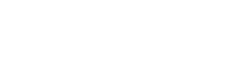

In [ ]:
# Check out your results at './SkyAR/demo.avi' and './SkyAR/demo-cat.avi'. 
# Download them and enjoy.

# If you would like to pre-view your results. Run the following to see the animated 
# results of the first 40 frames.

import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(4,8))
plt.axis('off')
ims = [[plt.imshow(img[:,:,::-1], animated=True)] for img in sf.output_img_list[0:40]]
ani = animation.ArtistAnimation(fig, ims, interval=50)

HTML(ani.to_jshtml())